# Regression on Base Healthy Caloric Intake 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import Input

2024-12-09 23:10:18.512866: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sklearn
sklearn.__version__

'1.4.2'

## Config

In [3]:
EPOCHS = 500
BATCH_SIZE=8
VERBOSE_TRAINING=False
RANDOM_STATE=42

In [4]:
def set_random_state(seed=RANDOM_STATE):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_random_state()

## Data

In [5]:
# Change these path
df = pd.read_csv("./weight_change_dataset.csv")
df

,Participant ID,Age,Gender,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Final Weight (lbs)
0,1,56,M,228.4,3102.3,3916.0,813.7,0.20000,1,Sedentary,Excellent,6,228.6
1,2,46,F,165.4,2275.5,3823.0,1547.5,2.40000,6,Very Active,Excellent,6,167.8
2,3,32,F,142.8,2119.4,2785.4,666.0,1.40000,7,Sedentary,Good,3,144.2
3,4,25,F,145.5,2181.3,2587.3,406.0,0.80000,8,Sedentary,Fair,2,146.3
4,5,38,M,155.5,2463.8,3312.8,849.0,2.00000,10,Lightly Active,Good,1,157.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,59,M,181.9,2622.8,3656.2,1033.4,0.60000,2,Lightly Active,Excellent,3,182.5
96,97,56,F,116.5,1736.5,2756.5,1020.0,-8.92309,12,Moderately Active,Good,9,107.6
97,98,58,F,162.7,2188.6,3344.3,1155.8,3.60000,12,Lightly Active,Fair,7,166.3
98,99,45,M,179.8,2671.9,4000.0,1328.1,2.00000,5,Moderately Active,Fair,5,181.8


## Create Target Label

In [6]:
TARGET = "Healthy Caloric Intake"

# Define activity multipliers
activity_multipliers = {
    "Sedentary": 1.2,
    "Lightly Active": 1.375,
    "Moderately Active": 1.55,
    "Very Active": 1.725
}

# Calculate caloric adjustment based on weight change and duration
df['Caloric Adjustment'] = (df['Weight Change (lbs)'] * 3500) / (df['Duration (weeks)'] * 7)

# Calculate healthy caloric intake
df[TARGET] = (
    df['BMR (Calories)'] * df['Physical Activity Level'].map(activity_multipliers) + df['Caloric Adjustment']
)

In [7]:
df

,Participant ID,Age,Gender,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Final Weight (lbs),Caloric Adjustment,Healthy Caloric Intake
0,1,56,M,228.4,3102.3,3916.0,813.7,0.20000,1,Sedentary,Excellent,6,228.6,100.000000,3822.760000
1,2,46,F,165.4,2275.5,3823.0,1547.5,2.40000,6,Very Active,Excellent,6,167.8,200.000000,4125.237500
2,3,32,F,142.8,2119.4,2785.4,666.0,1.40000,7,Sedentary,Good,3,144.2,100.000000,2643.280000
3,4,25,F,145.5,2181.3,2587.3,406.0,0.80000,8,Sedentary,Fair,2,146.3,50.000000,2667.560000
4,5,38,M,155.5,2463.8,3312.8,849.0,2.00000,10,Lightly Active,Good,1,157.5,100.000000,3487.725000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,59,M,181.9,2622.8,3656.2,1033.4,0.60000,2,Lightly Active,Excellent,3,182.5,150.000000,3756.350000
96,97,56,F,116.5,1736.5,2756.5,1020.0,-8.92309,12,Moderately Active,Good,9,107.6,-371.795424,2319.779576
97,98,58,F,162.7,2188.6,3344.3,1155.8,3.60000,12,Lightly Active,Fair,7,166.3,150.000000,3159.325000
98,99,45,M,179.8,2671.9,4000.0,1328.1,2.00000,5,Moderately Active,Fair,5,181.8,200.000000,4341.445000


In [8]:
# Drop data that leaks information
to_drop = ["Participant ID", "BMR (Calories)", "Daily Caloric Surplus/Deficit", "Final Weight (lbs)"]

df.drop(columns=to_drop, axis=1, inplace=True)

df

,Age,Gender,Current Weight (lbs),Daily Calories Consumed,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Caloric Adjustment,Healthy Caloric Intake
0,56,M,228.4,3916.0,0.20000,1,Sedentary,Excellent,6,100.000000,3822.760000
1,46,F,165.4,3823.0,2.40000,6,Very Active,Excellent,6,200.000000,4125.237500
2,32,F,142.8,2785.4,1.40000,7,Sedentary,Good,3,100.000000,2643.280000
3,25,F,145.5,2587.3,0.80000,8,Sedentary,Fair,2,50.000000,2667.560000
4,38,M,155.5,3312.8,2.00000,10,Lightly Active,Good,1,100.000000,3487.725000
...,...,...,...,...,...,...,...,...,...,...,...
95,59,M,181.9,3656.2,0.60000,2,Lightly Active,Excellent,3,150.000000,3756.350000
96,56,F,116.5,2756.5,-8.92309,12,Moderately Active,Good,9,-371.795424,2319.779576
97,58,F,162.7,3344.3,3.60000,12,Lightly Active,Fair,7,150.000000,3159.325000
98,45,M,179.8,4000.0,2.00000,5,Moderately Active,Fair,5,200.000000,4341.445000


## Split Training and Test

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [10]:
train_set

,Age,Gender,Current Weight (lbs),Daily Calories Consumed,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Caloric Adjustment,Healthy Caloric Intake
55,23,F,185.0,3327.8,2.000000,10,Sedentary,Good,3,100.000000,3204.400000
88,28,M,209.0,4000.0,-4.454839,10,Lightly Active,Poor,3,-222.741957,3969.495543
26,44,M,191.8,4000.0,3.600000,12,Moderately Active,Fair,1,150.000000,4485.505000
42,43,M,182.8,4000.0,2.800000,7,Very Active,Good,2,200.000000,4878.545000
69,40,F,137.2,3827.8,-10.263076,9,Very Active,Poor,1,-570.170895,2920.021605
...,...,...,...,...,...,...,...,...,...,...,...
60,43,M,173.3,4000.0,4.400000,11,Moderately Active,Good,5,200.000000,4255.420000
71,38,F,145.9,3734.5,-1.394358,1,Very Active,Poor,9,-697.179152,2960.683348
14,20,F,168.1,3885.8,-2.330964,8,Very Active,Poor,7,-145.685227,4049.859773
92,52,M,169.9,3269.5,1.600000,8,Sedentary,Fair,2,100.000000,3144.760000


## Data Stats

In [11]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 55 to 51
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      80 non-null     int64  
 1   Gender                   80 non-null     object 
 2   Current Weight (lbs)     80 non-null     float64
 3   Daily Calories Consumed  80 non-null     float64
 4   Weight Change (lbs)      80 non-null     float64
 5   Duration (weeks)         80 non-null     int64  
 6   Physical Activity Level  80 non-null     object 
 7   Sleep Quality            80 non-null     object 
 8   Stress Level             80 non-null     int64  
 9   Caloric Adjustment       80 non-null     float64
 10  Healthy Caloric Intake   80 non-null     float64
dtypes: float64(5), int64(3), object(3)
memory usage: 7.5+ KB


In [12]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 83 to 31
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      20 non-null     int64  
 1   Gender                   20 non-null     object 
 2   Current Weight (lbs)     20 non-null     float64
 3   Daily Calories Consumed  20 non-null     float64
 4   Weight Change (lbs)      20 non-null     float64
 5   Duration (weeks)         20 non-null     int64  
 6   Physical Activity Level  20 non-null     object 
 7   Sleep Quality            20 non-null     object 
 8   Stress Level             20 non-null     int64  
 9   Caloric Adjustment       20 non-null     float64
 10  Healthy Caloric Intake   20 non-null     float64
dtypes: float64(5), int64(3), object(3)
memory usage: 1.9+ KB


## Encode Categorical Features

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_encoded = X.copy()

        cat_cols = X.select_dtypes(include=['object'])

        for col in cat_cols:

            # Perform one-hot encoding
            X_encoded = pd.concat([X_encoded, pd.get_dummies(X_encoded[col], prefix=col)], axis=1)

            # Drop original categorical columns from DataFrame
            X_encoded.drop(col, axis=1, inplace=True)

        return X_encoded

## Scale Numerical Features

In [14]:
from sklearn.preprocessing import StandardScaler

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = None
        self.numerical_cols = None

    def fit(self, X, y=None):
        self.numerical_cols = X.select_dtypes(include=['int', 'float']).drop([TARGET], axis=1).columns

        self.scaler = StandardScaler().fit(X[self.numerical_cols])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])

        return X_scaled

    def inverse_transform(self, X):
        X_inverse = X.copy()
        X_inverse[self.numerical_cols] = self.scaler.inverse_transform(X[self.numerical_cols])

        return X_inverse

## Compile Preprocessing

In [15]:
from sklearn.pipeline import Pipeline

pipeline_train = Pipeline([
    ("scaler", FeatureScaler()),
    ("encoder", FeatureEncoder())
])

In [16]:
train_set = pipeline_train.fit_transform(train_set)
test_set = pipeline_train.transform(test_set)

In [17]:
def match_columns(train, test):
    # Get list of columns in training set
    train_cols = train.columns.tolist()

    # Get list of columns in test set
    test_cols = test.columns.tolist()

    # Remove any columns in test set that aren't in training set
    for col in test_cols:
        if col not in train_cols:
            test = test.drop(col, axis=1)

    # Add any missing columns to test set and fill with 0
    for col in train_cols:
        if col not in test_cols:
            test[col] = 0

    # Reorder columns in test set to match training set
    test = test[train_cols]

    # Return modified test set
    return test

In [18]:
test_set = match_columns(train_set, test_set)

In [19]:
train_set.head()

,Age,Current Weight (lbs),Daily Calories Consumed,Weight Change (lbs),Duration (weeks),Stress Level,Caloric Adjustment,Healthy Caloric Intake,Gender_F,Gender_M,Physical Activity Level_Lightly Active,Physical Activity Level_Moderately Active,Physical Activity Level_Sedentary,Physical Activity Level_Very Active,Sleep Quality_Excellent,Sleep Quality_Fair,Sleep Quality_Good,Sleep Quality_Poor
55,-1.232972,0.571342,-0.346257,0.646814,0.878276,-0.747946,0.706859,3204.400000,True,False,False,False,True,False,False,False,True,False
88,-0.815015,1.426018,0.995206,-0.157369,0.878276,-0.747946,0.028890,3969.495543,False,True,True,False,False,False,False,False,False,True
26,0.522446,0.813500,0.995206,0.846152,1.456564,-1.545755,0.811892,4485.505000,False,True,False,True,False,False,False,True,False,False
42,0.438854,0.492997,0.995206,0.746483,0.010843,-1.146850,0.916925,4878.545000,False,True,False,False,False,True,False,False,True,False
69,0.188080,-1.130888,0.651558,-0.880994,0.589131,-1.545755,-0.700938,2920.021605,True,False,False,False,False,True,False,False,False,True


In [20]:
test_set.head()

,Age,Current Weight (lbs),Daily Calories Consumed,Weight Change (lbs),Duration (weeks),Stress Level,Caloric Adjustment,Healthy Caloric Intake,Gender_F,Gender_M,Physical Activity Level_Lightly Active,Physical Activity Level_Moderately Active,Physical Activity Level_Sedentary,Physical Activity Level_Very Active,Sleep Quality_Excellent,Sleep Quality_Fair,Sleep Quality_Good,Sleep Quality_Poor
83,-0.982198,-1.561787,-1.703286,0.547145,1.456564,0.448768,0.601826,2713.160000,False,True,False,False,True,False,False,False,True,False
53,-1.400155,0.439580,0.995206,0.256134,-0.567446,1.645481,0.258196,4237.422362,False,True,False,True,False,False,False,True,False,False
70,1.609133,-2.455636,-2.934390,0.191035,-1.724023,1.645481,-1.245014,1324.763935,True,False,True,False,False,False,False,False,True,False
45,0.606037,1.027169,0.995206,0.995655,1.456564,0.847672,0.916925,4236.820000,True,False,False,True,False,False,False,False,True,False
44,-0.062693,0.553536,-0.189600,-0.223797,-1.145734,1.645481,-1.249560,2478.622079,False,True,False,False,True,False,False,True,False,False


In [21]:
test_set.columns

Index(['Age', 'Current Weight (lbs)', 'Daily Calories Consumed',
       'Weight Change (lbs)', 'Duration (weeks)', 'Stress Level',
       'Caloric Adjustment', 'Healthy Caloric Intake', 'Gender_F', 'Gender_M',
       'Physical Activity Level_Lightly Active',
       'Physical Activity Level_Moderately Active',
       'Physical Activity Level_Sedentary',
       'Physical Activity Level_Very Active', 'Sleep Quality_Excellent',
       'Sleep Quality_Fair', 'Sleep Quality_Good', 'Sleep Quality_Poor'],
      dtype='object')

## Modelling

In [22]:
# Define the Neural Network
def create_nn_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

# Compile and Train the Model
def train_nn_model(X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE_TRAINING):
    model = create_nn_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=MeanSquaredError(),
                  metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )
    return model, history

## Training and Evaluation

In [23]:
# Split to X and y
X_train = train_set.drop([TARGET], axis=1).values
y_train = train_set[TARGET]

X_test = test_set.drop([TARGET], axis=1).values
y_test = test_set[TARGET]

In [24]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [25]:
model, history = train_nn_model(X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE_TRAINING)

In [26]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Time')
    plt.legend()
    plt.grid()
    plt.show()

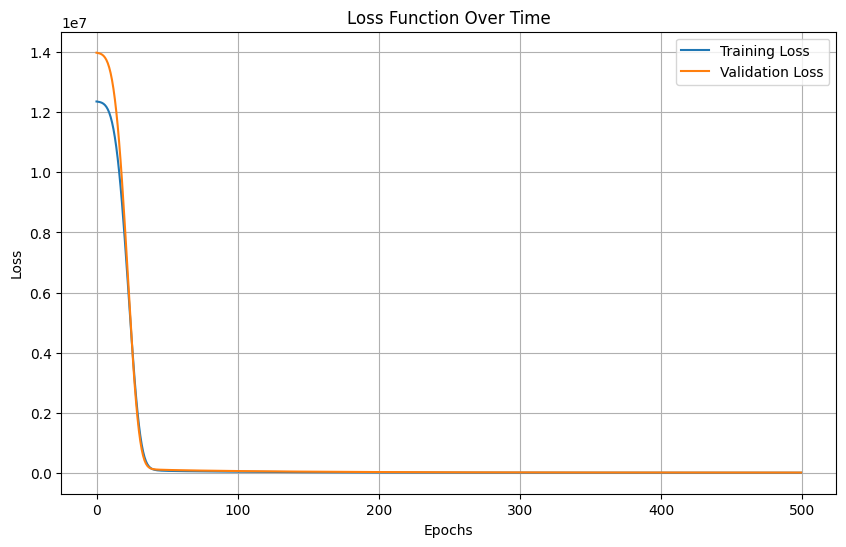

In [27]:
plot_loss(history)

In [28]:
from sklearn.metrics import mean_squared_error
import math

# Training Score
y_pred_train = model.predict(X_train)
train_rmse = math.sqrt(mean_squared_error(y_train, y_pred_train))
print("Training RMSE:", train_rmse)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Training RMSE: 43.51699952945831


In [29]:
# Test Score
y_pred_test = model.predict(X_test)
test_rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
print("Testing RMSE:", test_rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Testing RMSE: 84.94914896663916


In [30]:
y_test.tolist()

[2713.159912109375,
 4237.42236328125,
 1324.763916015625,
 4236.81982421875,
 2478.6220703125,
 3317.03759765625,
 4067.1298828125,
 4969.8154296875,
 4394.61767578125,
 3822.760009765625,
 4790.39013671875,
 4280.77490234375,
 3143.673828125,
 3141.303466796875,
 4127.10009765625,
 3487.72509765625,
 3727.33740234375,
 3601.689697265625,
 2546.800048828125,
 4343.60205078125]

In [31]:
y_pred_test.tolist()

[[2628.860107421875],
 [4243.5888671875],
 [1562.671142578125],
 [4243.9970703125],
 [2511.321044921875],
 [3257.018798828125],
 [4183.349609375],
 [4945.6025390625],
 [4330.9013671875],
 [3989.044189453125],
 [4801.427734375],
 [4329.98583984375],
 [3156.380126953125],
 [3110.040771484375],
 [4168.04541015625],
 [3480.301513671875],
 [3740.826904296875],
 [3629.591064453125],
 [2396.567626953125],
 [4310.25341796875]]

## Save the Model

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,877 (124.52 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,252 (83.02 KB)

In [33]:
model.save('exp1.h5')

## Sample User Input

In [34]:
input_data = {
    "Age": 20,
    "Gender": "F",
    "Daily Calories Consumed": 1700,
    "Weight Change (lbs)": 5.0,
    "Duration (weeks)": 10,
    "Physical Activity Level": "Sedentary",
    "Sleep Quality": "Excellent",
    "Stress Level": 3,
    "Current Weight (lbs)": 101,
    "Caloric Adjustment": 250
}

transformed_data = {
    'Age': input_data['Age'],
    'Current Weight (lbs)': input_data['Current Weight (lbs)'],
    'Daily Calories Consumed': input_data['Daily Calories Consumed'],
    'Weight Change (lbs)': input_data['Weight Change (lbs)'],
    'Duration (weeks)': input_data['Duration (weeks)'],
    'Stress Level': input_data['Stress Level'],
    'Caloric Adjustment': input_data['Caloric Adjustment'],
    'Gender_F': 1 if input_data['Gender'] == 'F' else 0,
    'Gender_M': 1 if input_data['Gender'] == 'M' else 0,
    'Physical Activity Level_Lightly Active': 1 if input_data['Physical Activity Level'] == 'Active' else 0,
    'Physical Activity Level_Moderately Active': 1 if input_data['Physical Activity Level'] == 'Moderately Active' else 0,
    'Physical Activity Level_Sedentary': 1 if input_data['Physical Activity Level'] == 'Sedentary' else 0,
    'Physical Activity Level_Very Active': 1 if input_data['Physical Activity Level'] == 'Very Active' else 0,
    'Sleep Quality_Excellent': 1 if input_data['Sleep Quality'] == 'Excellent' else 0,
    'Sleep Quality_Fair': 1 if input_data['Sleep Quality'] == 'Fair' else 0,
    'Sleep Quality_Good': 1 if input_data['Sleep Quality'] == 'Good' else 0,
    'Sleep Quality_Poor': 1 if input_data['Sleep Quality'] == 'Poor' else 0,
}

input_df = pipeline_train.transform(pd.DataFrame([transformed_data]))

In [35]:
input_df

,Age,Current Weight (lbs),Daily Calories Consumed,Weight Change (lbs),Duration (weeks),Stress Level,Caloric Adjustment,Gender_F,Gender_M,Physical Activity Level_Lightly Active,Physical Activity Level_Moderately Active,Physical Activity Level_Sedentary,Physical Activity Level_Very Active,Sleep Quality_Excellent,Sleep Quality_Fair,Sleep Quality_Good,Sleep Quality_Poor
0,-1.483746,-2.420024,-3.594745,1.020572,0.878276,-0.747946,1.021957,1,0,0,0,1,0,1,0,0,0


In [36]:
input_df.shape

(1, 17)

In [37]:
model.predict(input_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[2358.9265]], dtype=float32)

## Serialize Pipeline

In [38]:
import dill

with open('pipeline.pkl', 'wb') as f:
    dill.dump(pipeline_train, f)

In [39]:
with open('pipeline.pkl', 'rb') as f:
    loaded_pipeline = dill.load(f)
    test_loaded = loaded_pipeline.transform(pd.DataFrame([transformed_data]))

    print(model.predict(test_loaded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
[[2358.9265]]
